<a href="https://colab.research.google.com/github/leehyeonjin99/BOOSTCAMP_AI_Tech_Study_Diary/blob/main/%EB%85%BC%EB%AC%B8review/Network%20%EA%B5%AC%ED%98%84/EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from math import ceil

base_model=[
            # expand_ratio, channel, repaeats, stride, kernel_size
            [1,16,1,1,3],
            [6,24,2,2,3],
            [6,40,2,2,5],
            [6,80,3,2,3],
            [6,112,3,1,5],
            [6,192,4,2,5],
            [6,320,1,1,3]
]

phi_values={
    # list of : [phi_value, resolution, drop_rate]
    "b0":[0, 224, 0.2], #alpha, bate, gamma, depth=alph**phi
    "b1":[0.5, 240, 0.2],
    "b2":[1, 260, 0.3],
    "b3":[2, 300, 0.3],
    "b4":[3, 300, 0.4],
    "b5":[4, 456, 0.4],
    "b6":[5, 528, 0.5],
    "b7":[6, 600, 0.5]
}

In [ ]:
class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups=1):
    super(CNNBlock, self).__init__()
    self.cnn=nn.Conv2d(in_channels, 
                       out_channels, 
                       kernel_size, 
                       stride,
                       padding, 
                       groups=groups,
                       bias=False)
    self.bn=nn.BatchNorm2d(out_channels)
    self.silu=nn.SiLU()

  def forward(self, x):
    return self.silu(self.bn(self.cnn(x)))

In [ ]:
class SqueezeExcitation(nn.Module):
  def __init__(self, in_channels, reduced_dim):
    super(SqueezeExcitation,self).__init__()

    self.se=nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(in_channels, reduced_dim, 1),
        nn.SiLU(),
        nn.Conv2d(reduced_dim, in_channels, 1),
        nn.Sigmoid() # 0과 1 사이의 값으로 각 채널 별 중요도 계산
    )

  def forward(self, x):
    return x*self.se(x)

In [ ]:
class InvertedResidualBlock(nn.Module):
  def __init__(self, 
               in_channels, 
               out_channels, 
               kernel_size, 
               stride, 
               padding, 
               expand_ratio, 
               reduction=4, # squeeze excitation
               survival_prob=0.8, # for stochastic depth
               ):
    super(InvertedResidualBlock, self).__init__()

    self.survival_prob = survival_prob
    self.use_residual = in_channels==out_channels and stride==1 # feature map의 size 일정할 떄만 residual 사용
    hidden_dim=in_channels*expand_ratio
    self.expand=in_channels!=hidden_dim
    reduced_dim=int(in_channels/reduction)

    if self.expand:
      self.expand_conv=CNNBlock(in_channels, hidden_dim, kernel_size=3, stride=1, padding=1)
    
    self.conv=nn.Sequential(
        CNNBlock(hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim),
        SqueezeExcitation(hidden_dim, reduced_dim),
        nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
        nn.BatchNorm2d(out_channels)
    )

  def stochastic_depth(self,x):
    if not self.training: # training 모드가 아닌 경우
      return x

    binary_tensor=torch.rand(x.shape[0],1,1,1,device=x.device) < self.survival_prob
    
    return torch.div(x, self.survival_prob) * binary_tensor 

  def forward(self, x):
    output=self.expand_conv(x) if self.expand else x

    if self.use_residual:
      return self.stochastic_depth(self.conv(output)) + x
    else:
      return self.conv(output)

In [ ]:
class EfficientNet(nn.Module):
  def __init__(self, version, num_classes):
    super(EfficientNet, self).__init__()

    width_factor, depth_factor, dropout_rate=self.calculate_factors(version)
    last_channels=ceil(1280*width_factor)
    self.pool=nn.AdaptiveAvgPool2d(1)
    self.features=self.create_features(width_factor, depth_factor, last_channels)
    self.classifier=nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(last_channels, num_classes)
    )

  def calculate_factors(self, version, alpha=1.2, beta=1.1):
    phi,res, drop_rate=phi_values[version]
    depth_factor=alpha**phi
    width_factor=beta**phi
    return width_factor, depth_factor, drop_rate

  def create_features(self, width_factor, depth_factor, last_channels):
    channels=int(32*width_factor)
    features=[CNNBlock(3, channels, 3, stride=2, padding=1)]
    in_channels=channels

    for expand_ratio, channels, repeats, stride, kernel_size in base_model:
      out_channels=4*ceil(int(channels*width_factor)/4)
      layers_repeats=ceil(repeats*depth_factor)

      for layer in range(layers_repeats):
        features.append(
            InvertedResidualBlock(in_channels, 
                                  out_channels,
                                  kernel_size, 
                                  stride=stride if layer==0 else 1,
                                  expand_ratio=expand_ratio,
                                  padding=kernel_size//2))
        in_channels=out_channels

    features.append(
        CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
    )

    return nn.Sequential(*features)

  def forward(self, x):
    output=self.pool(self.features(x))
    return self.classifier(output.view(x.shape[0],-1))

In [ ]:
def test():
  device='cuda' if torch.cuda.is_available() else'cpu'
  version='b0'
  phi, res, drop_rate = phi_values[version]
  num_examples, num_classes=4,10
  x=torch.randn((num_examples, 3, res, res)).to(device)
  model=EfficientNet(version=version, num_classes=num_classes).to(device)

  print(model(x).shape)

In [ ]:
test()

torch.Size([4, 10])


In [76]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models

from torchvision import utils
import matplotlib.pyplot as plt


transformer=transforms.Compose([transforms.ToTensor(),
                               transforms.Resize(224)])

train_ds = datasets.STL10('/data', split='train', download=True, transform=transformer)
val_ds = datasets.STL10('/data', split='test', download=True, transform=transformer)

loader_train=DataLoader(train_ds, batch_size=32, shuffle=True)
loader_valid=DataLoader(val_ds, batch_size=32, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


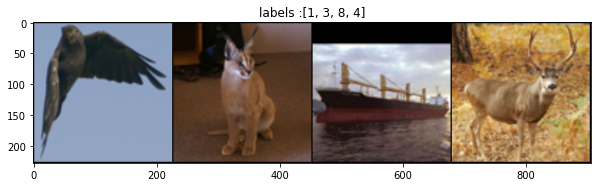

In [ ]:
import numpy as np

def show(img, y=None):
  npimg=img.numpy()
  npimg_tr=npimg.transpose(1,2,0)
  plt.imshow(npimg_tr)

  if y is not None:
    if type(y)=='str':
      plt.title('labels :'+y)
    else:
      plt.title('labels :'+str(y))

np.random.seed(10)
torch.manual_seed(10)

grid_size=4
rnd_ind=np.random.randint(0,len(train_ds),grid_size)

x_grid=[train_ds[i][0] for i in rnd_ind]
y_grid=[train_ds[i][1] for i in rnd_ind]

x_grid=utils.make_grid(x_grid, nrow=grid_size, padding=2)
plt.figure(figsize=(10,10))
show(x_grid, y_grid)

In [ ]:
class_mapping={idx:typ  for idx, typ in enumerate(train_ds.classes)}
class_mapping

{0: 'airplane',
 1: 'bird',
 2: 'car',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'horse',
 7: 'monkey',
 8: 'ship',
 9: 'truck'}

In [ ]:
device='cuda' if torch.cuda.is_available() else'cpu'
version='b0'
num_examples, num_classes=4,10
model=EfficientNet(version=version, num_classes=num_classes).to(device)

import torch.optim as optim
import torch.nn.functional as F

num_epoch=20
lr=0.001
optimizer=optim.Adam(model.parameters(), lr=lr)
loss=nn.CrossEntropyLoss()

for epoch in range(num_epoch):
  print(f"=========={epoch+1} epoch of {num_epoch}==========")
  
  model.train()
  train_loss=0
  total_cnt=0
  valid_correct=0
  correct=0
  total_cnt=0
  valid_cnt=0

  for X, y in loader_train:
    X=X.to(device)
    y=y.to(device)

    hypothesis=model(X)
    L=loss(hypothesis, y)

    optimizer.zero_grad()
    L.backward()
    optimizer.step()

    train_loss+=L.item()
    total_cnt+=len(y)
    correct+=torch.sum(torch.argmax(hypothesis, dim=1)==y)

  print(f"Train : Acc = {correct/total_cnt:.4f} / Loss = {train_loss/total_cnt}")

  model.eval()

  for X, y in loader_valid:
    X=X.to(device)
    y=y.to(device)

    hypothesis=model(X)
    predict=torch.argmax(hypothesis, dim=1)
    valid_correct+=torch.sum(predict==y)
    valid_cnt+=len(y)

  print(f"Valid : Acc = {valid_correct/valid_cnt:.4f}")

==========1 epoch of 20==========
Train : Acc = 0.2136 / Loss = 0.06193445007801056
Valid : Acc = 0.2914
==========2 epoch of 20==========
Train : Acc = 0.2942 / Loss = 0.05403273766040802
Valid : Acc = 0.3235
==========3 epoch of 20==========
Train : Acc = 0.3232 / Loss = 0.051703263926506045
Valid : Acc = 0.3186
==========4 epoch of 20==========
Train : Acc = 0.3718 / Loss = 0.04923727569580078
Valid : Acc = 0.3974
==========5 epoch of 20==========
Train : Acc = 0.4266 / Loss = 0.04568443217277527
Valid : Acc = 0.4266
==========6 epoch of 20==========
Train : Acc = 0.4780 / Loss = 0.04216708544492721
Valid : Acc = 0.4689
==========7 epoch of 20==========
Train : Acc = 0.5220 / Loss = 0.03994038920402527
Valid : Acc = 0.4955
==========8 epoch of 20==========
Train : Acc = 0.5514 / Loss = 0.03748889443874359
Valid : Acc = 0.5158
==========9 epoch of 20==========
Train : Acc = 0.5970 / Loss = 0.0338335492014885
Valid : Acc = 0.5841
==========10 epoch of 20==========
Train : Acc = 0.6276

correct : ['deer', 'monkey', 'monkey', 'monkey']


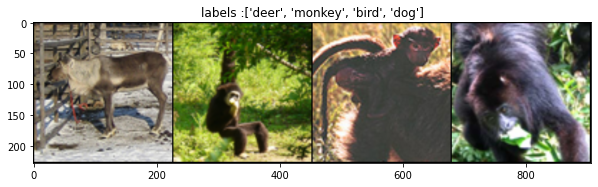

In [ ]:
model.eval()
data=next(iter(loader_valid))
hypothesis=model(data[0].to(device))
pred=torch.argmax(hypothesis, dim=1)

grid_size=4

x_grid=data[0][:4]
y_grid=[class_mapping[i.item()] for i in pred[:4]]

x_grid=utils.make_grid(x_grid, nrow=grid_size, padding=2)
plt.figure(figsize=(10,10))
show(x_grid, y_grid)

print("correct :",[class_mapping[i.item()] for i in data[1][:4]])

In [ ]:
class_mapping

{0: 'airplane',
 1: 'bird',
 2: 'car',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'horse',
 7: 'monkey',
 8: 'ship',
 9: 'truck'}

In [69]:
pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=a50a487aa92f02a3066a79bba3d2cf78b7b40c0f4bead7418da94959e1f315a2
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [96]:
from efficientnet_pytorch import EfficientNet
efficient = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [102]:
input=torch.rand(1,3,224,224)
print(input.shape)
features=efficient.extract_features(input)
print(features.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 1280, 7, 7])


In [103]:
device='cuda' if torch.cuda.is_available() else'cpu'
efficient=efficient.to(device)

import torch.optim as optim
import torch.nn.functional as F

num_epoch=20
lr=0.001
optimizer=optim.Adam(efficient.parameters(), lr=lr)
loss=nn.CrossEntropyLoss()

for epoch in range(num_epoch):
  print(f"=========={epoch+1} epoch of {num_epoch}==========")
  
  efficient.train()
  train_loss=0
  total_cnt=0
  valid_correct=0
  correct=0
  total_cnt=0
  valid_cnt=0

  for X, y in loader_train:
    X=X.to(device)
    y=y.to(device)

    hypothesis=efficient(X)
    L=loss(hypothesis, y)

    optimizer.zero_grad()
    L.backward()
    optimizer.step()

    train_loss+=L.item()
    total_cnt+=len(y)
    correct+=torch.sum(torch.argmax(hypothesis, dim=1)==y)

  print(f"Train : Acc = {correct/total_cnt:.4f} / Loss = {train_loss/total_cnt}")

  efficient.eval()

  for X, y in loader_valid:
    X=X.to(device)
    y=y.to(device)

    hypothesis=efficient(X)
    predict=torch.argmax(hypothesis, dim=1)
    valid_correct+=torch.sum(predict==y)
    valid_cnt+=len(y)

  print(f"Valid : Acc = {valid_correct/valid_cnt:.4f}")

==========1 epoch of 20==========
Train : Acc = 0.8212 / Loss = 0.022718266132473946
Valid : Acc = 0.8840
==========2 epoch of 20==========
Train : Acc = 0.9358 / Loss = 0.0063971386455930765
Valid : Acc = 0.8964
==========3 epoch of 20==========
Train : Acc = 0.9572 / Loss = 0.004200507516413927
Valid : Acc = 0.8956
==========4 epoch of 20==========
Train : Acc = 0.9594 / Loss = 0.003742224500607699
Valid : Acc = 0.9025
==========5 epoch of 20==========
Train : Acc = 0.9698 / Loss = 0.0028814755049999803
Valid : Acc = 0.9041
==========6 epoch of 20==========
Train : Acc = 0.9700 / Loss = 0.0028616978622507303
Valid : Acc = 0.8911
==========7 epoch of 20==========
Train : Acc = 0.9758 / Loss = 0.002427182486234233
Valid : Acc = 0.9105
==========8 epoch of 20==========
Train : Acc = 0.9784 / Loss = 0.0018956208420684562
Valid : Acc = 0.8929
==========9 epoch of 20==========
Train : Acc = 0.9750 / Loss = 0.0026576277715852485
Valid : Acc = 0.9001
==========10 epoch of 20==========
Train 

KeyboardInterrupt: ignored

correct : ['ship', 'ship', 'ship', 'horse']


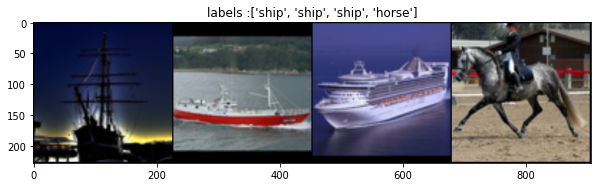

In [107]:
efficient.eval()
data=next(iter(loader_valid))
hypothesis=efficient(data[0].to(device))
pred=torch.argmax(hypothesis, dim=1)

grid_size=4

x_grid=data[0][:4]
y_grid=[class_mapping[i.item()] for i in pred[:4]]

x_grid=utils.make_grid(x_grid, nrow=grid_size, padding=2)
plt.figure(figsize=(10,10))
show(x_grid, y_grid)

print("correct :",[class_mapping[i.item()] for i in data[1][:4]])